In [58]:
from pyuvdata import UVData
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [129]:
use_uvfits = True

UV = UVData()
fhd_prefix = '/Users/ruby/EoR/fhd_bug_testing_Nov2019/vis_analytic_model_project/fhd_rlb_single_source_test_master_onefreq_Nov2019'
fhd_obs = '1130773144'
if use_uvfits:
    UV.read_uvfits('{}/model_vis.uvfits'.format(fhd_prefix))
else:
    fhd_files = [fhd_prefix + '/metadata/' + fhd_obs + '_settings.txt',
             fhd_prefix + '/metadata/' + fhd_obs + '_params.sav',
             fhd_prefix + '/vis_data/' + fhd_obs + '_flags.sav',
             fhd_prefix + '/vis_data/' + fhd_obs + '_vis_model_XX.sav',
             fhd_prefix + '/vis_data/' + fhd_obs + '_vis_model_YY.sav',
             fhd_prefix + '/vis_data/' + fhd_obs + '_vis_model_XY.sav',
             fhd_prefix + '/vis_data/' + fhd_obs + '_vis_model_YX.sav']
    UV.read_fhd(fhd_files, use_model=True)
    use_freq_hz = 167555000.
    UV.select(frequencies=use_freq_hz)
    #UV.write_uvfits('{}/model_vis.uvfits'.format(fhd_prefix), spoof_nonessential=True)

In [130]:
print(UV.phase_center_frame)

None


In [41]:
# get source information
source = scipy.io.readsav(
    '{}/output_data/{}_skymodel.sav'.format(fhd_prefix, fhd_obs), python_dict=True
)['skymodel']['source_list'][0]

source_loc_x = source['X'][0]
source_loc_y = source['Y'][0]
source_ra_deg = source['RA'][0]
source_dec_deg = source['DEC'][0]
source_flux = source['flux'][0]['I'][0]
source_flux_xx = source['flux'][0]['XX'][0]
source_flux_yy = source['flux'][0]['YY'][0]
source_flux_xy = source['flux'][0]['XY'][0]
source_flux_yx = source['flux'][0]['YX'][0]

In [49]:
start_phase_ra = UV.phase_center_ra
start_phase_dec = UV.phase_center_dec

start_data_array = np.copy(UV.data_array) # do a safe data copy
UV.unphase_to_drift()
UV.phase(np.deg2rad(source_ra_deg), np.deg2rad(source_dec_deg))
UV.data_array[:,:,:,0] = source_flux_xx
UV.data_array[:,:,:,1] = source_flux_yy
UV.data_array[:,:,:,2] = source_flux_xy
UV.data_array[:,:,:,3] = source_flux_yx
UV.unphase_to_drift()
UV.phase(start_phase_ra, start_phase_dec)

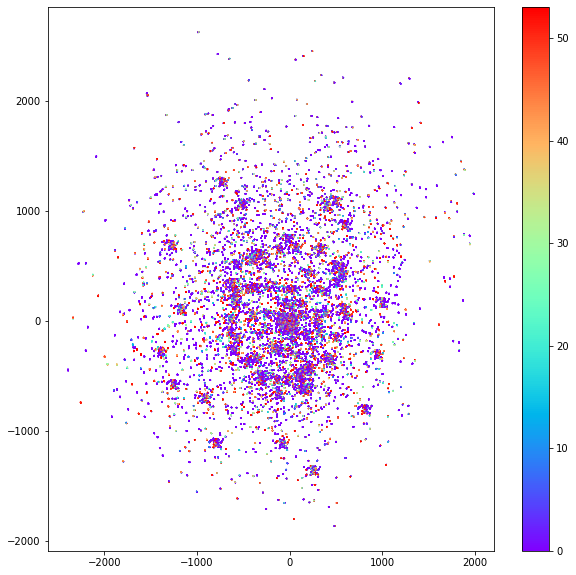

In [74]:
plt.figure(figsize=(10,10))
plt.scatter(
    UV.uvw_array[:,0], UV.uvw_array[:,1], c=np.real(UV.data_array[:,0,0,0]),
    cmap='rainbow', vmin=0, vmax=53, s=.1
)
plt.colorbar()
plt.show()

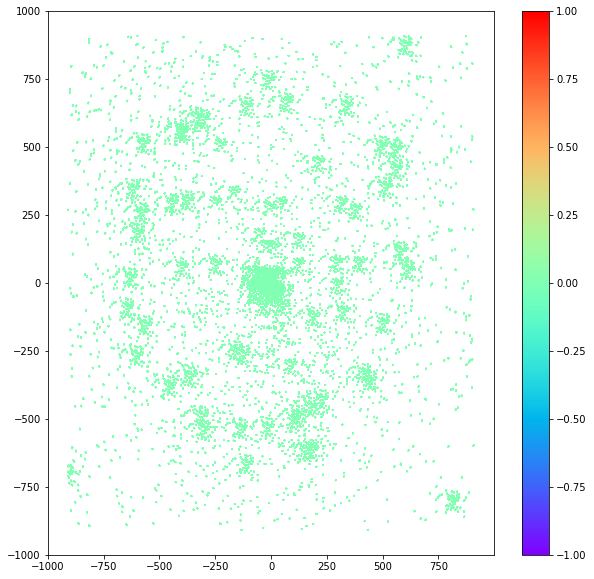

0.011195064


In [127]:
use_pol = 3
diff = np.abs(UV.data_array[:,0,0,use_pol]) - np.abs(start_data_array[:,0,0,use_pol])
zeros = np.where(start_data_array == 0.)
plot_diff = np.delete(diff, zeros)
plot_x = np.delete(UV.uvw_array[:,0], zeros)
plot_y = np.delete(UV.uvw_array[:,1], zeros)
plt.figure(figsize=(10,10))
plt.scatter(
    plot_x, plot_y, c=plot_diff,
    cmap='rainbow', vmin=-1, vmax=1, s=.1
)
#plt.xlim([-100, 100])
#plt.ylim([-100, 100])
plt.colorbar()
plt.show()
print(np.max(plot_diff))

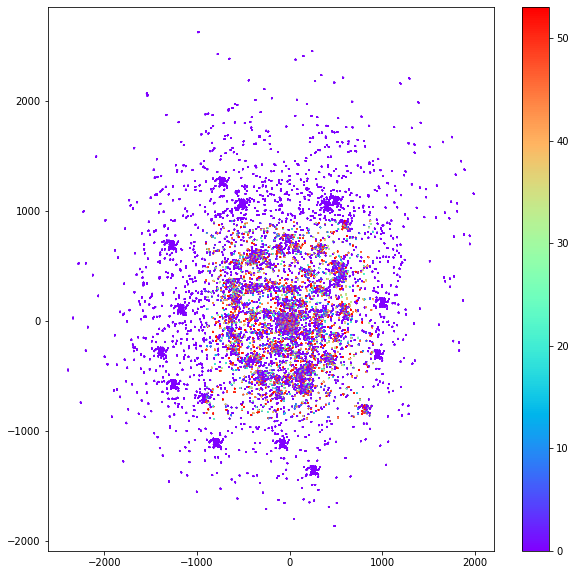

In [76]:
plt.figure(figsize=(10,10))
plt.scatter(
    UV.uvw_array[:,0], UV.uvw_array[:,1], c=np.real(start_data_array[:,0,0,0]),
    cmap='rainbow', vmin=0, vmax=53, s=.1
)
plt.colorbar()
plt.show()

In [128]:
print(UV.phase_center_frame)

icrs


In [55]:
print(UV.data_array[:10,0,0,0])
print(start_data_array[:10,0,0,0])
diff = UV.data_array - start_data_array
print(np.max(np.real(diff)))
np.shape(UV.uvw_array)

[ 53.301888  +0.j          2.6118693-53.237858j   44.89402  +28.733572j
  23.961187 +47.612526j  -33.108185 +41.772472j   16.396393 +50.71735j
   5.3779345+53.02989j    53.08668   -4.7849355j -23.389141 -47.89613j
 -34.48841  -40.64038j  ]
[ 52.416866  +0.41100174j   2.4121003-52.606594j
  44.833977 +28.475248j    24.477457 +46.921658j
 -32.111233 +42.09078j     16.966236 +50.073574j
   6.0171266+52.52679j     52.725365  -5.492322j
 -22.735487 -47.67318j    -33.91868  -40.552296j  ]
58.071133


(462336, 3)

In [ ]:
start_phase_ra = UV.phase_center_ra
start_phase_dec = UV.phase_center_dec

# get beam information
# arrays are read in transposed
beamxx = scipy.io.readsav(
    '{}/beams_from_beam_image/single_source_sim_beam_xx.sav'.format(fhd_prefix)
)['beam_base'].T
beamyy = scipy.io.readsav(
    '{}/beams_from_beam_image/single_source_sim_beam_yy.sav'.format(fhd_prefix)
)['beam_base'].T
beamxy = scipy.io.readsav(
    '{}/beams_from_beam_image/single_source_sim_beam_xy.sav'.format(fhd_prefix)
)['beam_base'].T
beamyx = scipy.io.readsav(
    '{}/beams_from_beam_image/single_source_sim_beam_yx.sav'.format(fhd_prefix)
)['beam_base'].T

beam_val_xx = scipy.interpolate.interp2d(
    list(range(2048)), list(range(2048)), beamxx
)(source_loc_y, source_loc_x)[0]
apparent_flux = source_flux*beam_val_xx

#start_data_array = np.copy(UV.data_array) # do a safe data copy
#UV.unphase_to_drift()
#UV.phase(np.deg2rad(source_ra_deg), np.deg2rad(source_dec_deg))
#UV.data_array.fill(apparent_flux)
#UV.unphase_to_drift()
#UV.phase(start_phase_ra, start_phase_dec)

In [43]:
a=np.full((3,3), fill_value=3.)

In [47]:
a[:,0] = 1.

In [48]:
a

array([[1., 3., 3.],
       [1., 3., 3.],
       [1., 3., 3.]])